In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [90]:
# third party libraries
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# default libraries
import datetime
import time

# local imports
from effcn.models import SmalNorbEcnBackbone, SmalNorbEcnDecoder, SmalNorbEffCapsNet
from effcn.layers import PrimaryCaps, FCCaps
from effcn.functions import margin_loss, max_norm_masking
from smallnorb.smallnorb import SmallNORB
from effcn.utils import count_parameters

In [94]:
#  using params from paper
BATCH_SIZE = 16
NUM_EPOCHS = 150
LEARNING_RATE = 5e-4 * 2**0
SCHEDULER_GAMMA = 0.96
REC_LOSS_WEIGHT = 0.392
NUM_WORKERS = 6

In [91]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
DEVICE = torch.device(dev)

In [92]:
print(DEVICE)

cpu


In [68]:
import torchvision.datasets as datasets

In [114]:
transform_train = T.Compose([
    T.Resize(64),
    T.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(1, 1)),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.Resize(64),
    T.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(1, 1)),
    T.ToTensor()
])

In [115]:
ds_train = SmallNORB(root='data/SmallNORB',train=True, download=True, transform=transform_train, mode="nopil")
ds_valid = SmallNORB(root='data/SmallNORB',train=False, download=True, transform=transform_valid, mode="nopil")


#
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)

In [116]:
ds_train[0][0].size()

torch.Size([2, 48, 48])

In [117]:
ds_valid[0][0].size()

torch.Size([2, 48, 48])

In [118]:
# plot train imgs
x, y, z = next(iter(dl_train))

x[:64,:1,:,:].size()
x[:64,1:2,:,:].size()

torch.Size([16, 1, 48, 48])

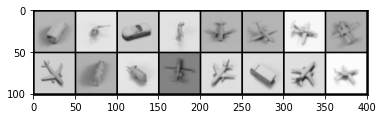

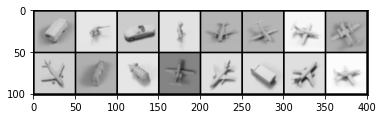

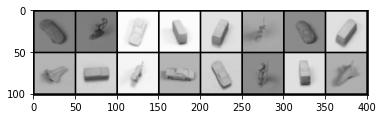

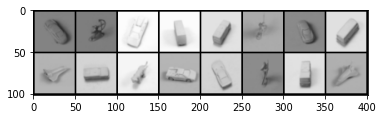

In [119]:
# plot train imgs
x, y, z = next(iter(dl_train))

# stereo channel 1
img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# stereo channel 2
img = torchvision.utils.make_grid(x[:64,1:2,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# plot valid imgs
x, y, z = next(iter(dl_valid))

# stereo channel 1
img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# stereo channel 2
img = torchvision.utils.make_grid(x[:64,1:2,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

## Train Model

In [81]:
model = SmalNorbEffCapsNet()
model = model.to(DEVICE)

In [82]:
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [85]:
# checkpointing
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
p_run = Path(P_CKTPS) / "run_{}".format(st)
p_run.mkdir(exist_ok=True, parents=True)

NameError: name 'P_CKTPS' is not defined

In [84]:
# training statistics
stats = {
    'acc_train': [],
    'acc_valid': [],
}

In [96]:
# print stuff
print("#" * 100)
print("#params:            {:,}".format(count_parameters(model)))
print("Using device:       {}".format(DEVICE))
print("Learning rate:      {}".format(LEARNING_RATE))
print("Batch size:         {}".format(BATCH_SIZE))
#print("Writing results to: {}".format(p_run))
print("#" * 100)

####################################################################################################
#params:            380,658
Using device:       cpu
Learning rate:      0.0005
Batch size:         16
####################################################################################################


In [103]:
epoch_loss = 0
epoch_correct = 0

num_epochs = 1
#
for epoch_idx in range(1, num_epochs +1):
    # ####################
    # TRAIN
    # ####################
    model.train()
    epoch_correct = 0
    epoch_total = 0
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x, y_true, _ in pbar:
        x = x.to(device)
        y_true = y_true.to(device)

        #optimizer.zero_grad()

        # way faster than optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
        
        u_h, x_rec = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=5)
        loss_margin = margin_loss(u_h, y_one_hot)
        loss_rec = torch.nn.functional.mse_loss(x, x_rec)
        loss_rec = REC_LOSS_WEIGHT * loss_rec
        
        #Total Loss
        loss = loss_margin + loss_rec
        loss.backward()
        
        optimizer.step()
        
        # validate batch
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        
        correct = (y_true == y_pred).sum()
        acc = correct / y_true.shape[0]
        
        epoch_correct += correct.item()
        epoch_loss += loss.item()
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'mar': loss_margin.item(),
                 'rec': loss_rec.item(),
                 'acc': acc.item()
                 }
        )
        break
    break
    
    
    lr_scheduler.step()
    # ####################
    # VALID
    # ####################
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true, _ in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            #u_l = model.primcaps(model.backbone(x))
            #u_h = model.fcncaps(u_l)
            u_h, x_rec = model.forward(x)            
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  1/  1]:██████████| 1519/1519 [09:49<00:00,  2.58it/s, loss=0.00457, mar=0.00202, rec=0.00255, acc=1]          


   acc_valid: 0.935
